## 2차 과제

- 주제: 데이터 크롤링을 활용한 뉴스 & 리뷰 데이터 분석
- 데이터: 자유롭게 크롤링
- 사용 라이브러리: selenium, beautifulsoup, etc.

### 1. 뉴스 기사 데이터 크롤링

1.1 원하는 뉴스 기사의 본문을 크롤링하시오.

In [28]:
from newspaper import Article

url = 'https://www.theguardian.com/world/2024/mar/12/south-korea-doctor-strike-government-suspends-medical-licenses'

article = Article(url)
article.download()
article.parse()

print(article.text)

South Korea’s government has started taking steps to suspend the medical licences of thousands of striking doctors, as concern grows that the month-long dispute is affecting frontline health care services.

The walkout by almost 12,000 doctors from 100 teaching hospitals has led to surgery cancellations, longer waiting times and delays in treatment, including for patients seeking emergency care, according to media reports.

The health ministry said it had put in motion procedures that could see 4,900 of the striking doctors lose their licences if they continue to defy orders to return to work.

The ministry also said it had sent administrative notifications, following up on warnings that strikers faced a three-month suspension – a punishment that could delay their ability to qualify as specialists for at least a year.

The increasingly acrimonious dispute began as a protest against government plans to dramatically raise the number of trainee doctors to address shortages in rural areas 

1.2 불용어를 제거하시오.

In [29]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import re

article_text = article.text

pattern = r'[^\w\s]'
article_text = re.sub(pattern, '', article_text)

stop_words = set(stopwords.words('english'))
word_tokens = word_tokenize(article_text)

words = [word.lower() for word in word_tokens if word.lower() not in stop_words]

1.3 크롤링한 본문을 단어 단위로 나누고 각 단어가 나온 횟수와 함께 dataframe 형식으로 변환하시오.

In [30]:
import re
import pandas as pd

df_word = pd.DataFrame({'word' : words})

df_word = df_word.groupby('word', as_index = False)\
                 .agg(n = ('word', 'count')) \
                 .sort_values('n', ascending = False)

df_word

,word,n
70,doctors,11
83,government,7
88,health,6
171,said,6
111,medical,5
...,...,...
81,frontline,1
82,give,1
84,greater,1
85,grievance,1


<Axes: xlabel='n', ylabel='word'>

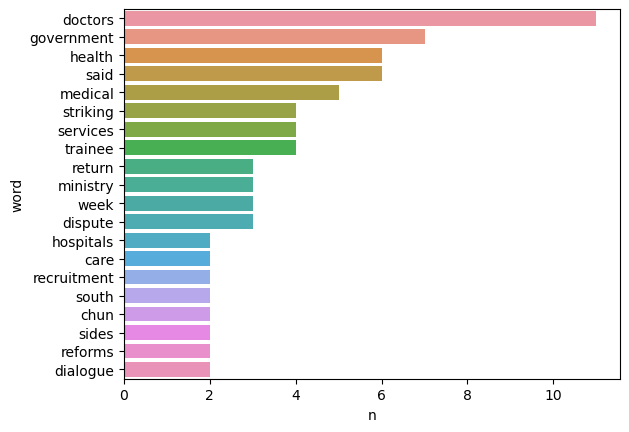

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(data = df_word.head(20), x = 'n', y = 'word')

1.4 처리한 데이터를 워드아트로 변환해 어떤 단어가 가장 많이 나왔는지 확인하시오(폰트, 색 등 자유).

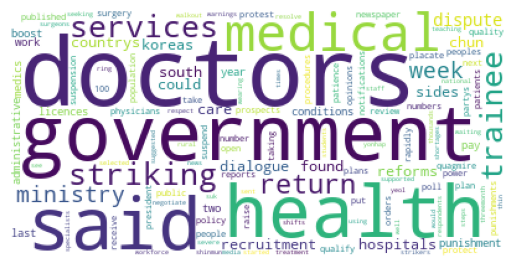

In [32]:
dic_word = df_word.set_index('word').to_dict()['n']
from wordcloud import WordCloud
wc = WordCloud(random_state = 1234,
                background_color = 'white')

img_WordCloud = wc.generate_from_frequencies(dic_word)
plt.axis('off')
plt.imshow(img_WordCloud)

### 2. 플레이스토어 리뷰 데이터 크롤링(동적 크롤링)

2.1 100개 이상의 리뷰를 가진 앱에 있는 댓글 리뷰를 크롤링하시오.

In [ ]:
from selenium import webdriver
from bs4 import BeautifulSoup
import time, os
from datetime import datetime
import pandas as pd
from selenium.webdriver.common.by import By

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--start-maxmized')
driver = webdriver.Chrome(options = chrome_options)

url = 'https://play.google.com/store/apps/details?id=com.netflix.mediaclient&hl=ko-KR'
driver.get(url)
time.sleep(3)

In [ ]:
# 날짜, 리뷰어, 리뷰, 별점 가져오기

from selenium.webdriver.common.by import By

dates = driver.find_elements(by = By.XPATH, value = '//span[@class = "bp9Aid"]')
reviewers = driver.find_elements(by = By.XPATH, value = '//div[@class = "X5PpBb"]')
reviews = driver.find_elements(by = By.XPATH, value = '//div[@class = "h3YV2d"]')
stargrades = driver.find_elements(by = By.XPATH, value = '//div[@class="iXRFPc"]')

In [ ]:
# 스크롤 최하단으로 내리기 + 리뷰 모두 보기
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

reviews = driver.find_element(by = By.XPATH, value = '//*[@id="yDmH0d"]/c-wiz[2]/div/div/div[1]/div/div[2]/div/div[1]/div[1]/c-wiz[5]/section/div/div[2]/div[5]/div/div/button/span')
isTrue = reviews.is_displayed()

if isTrue:
    driver.execute_script("arguments[0].click();", reviews)
    time.sleep(3)

all_reviews = driver.find_element(by = By.XPATH, value = '//*[@id="yDmH0d"]/c-wiz[2]/div/div/div[1]/div/div[2]/div/div[1]/div[1]/c-wiz[5]/section/div/div[2]/div[5]/div/div/button/div[3]')

for i in range(10000):
    driver.execute_script('arguments[0].scrollTop = arguments[0].scrollHeight;', all_reviews)

2.2 크롤링한 데이터를 dataframe 형태로 변환하시오(날짜, 별점, 리뷰 유저 등).

In [ ]:
data = pd.DataFrame(data = [], columns = ['DATES', 'REVIEWER', 'REVIEW', 'STARGRADES'])

dates = driver.find_elements(by = By.XPATH, value = '//span[@class = "bp9Aid"]')
reviewers = driver.find_elements(by = By.XPATH, value = '//div[@class = "X5PpBb"]')
reviews = driver.find_elements(by = By.XPATH, value = '//div[@class = "h3YV2d"]')
stargrades = driver.find_elements(by = By.XPATH, value = '//div[@class="iXRFPc"]')

for i in range(len(reviews)):
    tmp = []
    tmp.append(dates[i].text)
    tmp.append(reviewers[i].text)
    tmp.append(reviews[i].text)
    tmp.append(stargrades[i].get_attribute('aria-label'))

    tmp = pd.DataFrame(data = [tmp], columns = data.columns)
    data = pd.concat([data, tmp])

data.reset_index(inplace = True, drop = True)
data

,DATES,REVIEWER,REVIEW,STARGRADES
0,,,,별표 5개 만점에 4개를 받았습니다.
1,,,,별표 5개 만점에 5개를 받았습니다.
2,,,,별표 5개 만점에 4개를 받았습니다.
3,2024년 3월 9일,안웃어,앱과 핸드폰의 폰트를 다르게 설정할 수 있게 해주세요.. 평소에 둥글둥글한 폰트를 ...,별표 5개 만점에 4개를 받았습니다.
4,2024년 2월 29일,블리권,잘 사용하고 있엇는데 2주전부터 제가 저장하지 않은영상이 저장되고 있어요 리뷰쓰고 ...,별표 5개 만점에 5개를 받았습니다.
5,2024년 1월 28일,황수빈,영상 업데이트가 빨리 되는게 있는데 몇기에서 멈춰서 안 올라오거나 아주 느리게 올라...,별표 5개 만점에 4개를 받았습니다.
6,2024년 2월 13일,이윤희,재생버튼이 떠있을 때 원래는 화면 한번 터치하면 사라졌는데 지금은 이상하게 터치하면...,별표 5개 만점에 3개를 받았습니다.
7,2024년 2월 11일,이상훈,갤럭시23+ 사용자입니다# 다른건 렉이거 화면 검개변하거나 자막 오류 다이해가능합니...,별표 5개 만점에 1개를 받았습니다.
8,2024년 1월 20일,이현석,S22 사용잡니다. 예전부터 계속 widevine 강등문제가 있었지만 요즘들어 빈도...,별표 5개 만점에 1개를 받았습니다.
9,2024년 1월 24일,박소윤,최근들어 애니메이션 컨텐츠 업데이트가 잘 되고있지 않은것같다고 느꼈습니다 귀멸의 칼...,별표 5개 만점에 2개를 받았습니다.


2.3 긍정 리뷰와 부정 리뷰를 나누시오(기준은 자유).

In [ ]:
tmp = data.copy()
tmp['STARGRADES'] = tmp['STARGRADES'].apply(lambda x: x[5:])
m = re.compile('[0-9][\.0-9]*')

tmp['STARGRADES'] = tmp['STARGRADES'].apply(lambda x: m.findall(x)[0])
tmp['STARGRADES']

0     4
1     5
2     4
3     4
4     5
5     4
6     3
7     1
8     1
9     2
10    1
11    2
12    1
13    5
14    3
15    3
16    3
17    1
18    1
19    1
20    2
21    1
22    1
Name: STARGRADES, dtype: object

In [ ]:
tmp['STARGRADES'] = tmp['STARGRADES'].astype(float)
tmp_low = tmp[tmp['STARGRADES'] <= 3]
tmp_high = tmp[tmp['STARGRADES'] > 3]

tmp_high

,DATES,REVIEWER,REVIEW,STARGRADES
0,,,,4.0
1,,,,5.0
2,,,,4.0
3,2024년 3월 9일,안웃어,앱과 핸드폰의 폰트를 다르게 설정할 수 있게 해주세요.. 평소에 둥글둥글한 폰트를 ...,4.0
4,2024년 2월 29일,블리권,잘 사용하고 있엇는데 2주전부터 제가 저장하지 않은영상이 저장되고 있어요 리뷰쓰고 ...,5.0
5,2024년 1월 28일,황수빈,영상 업데이트가 빨리 되는게 있는데 몇기에서 멈춰서 안 올라오거나 아주 느리게 올라...,4.0
13,2019년 1월 12일,Google 사용자,"여러모로 굉장히 만족스럽게 쓰고 있습니다. 갤럭시 노트9 사용 중인데, 무선 미러링...",5.0


In [ ]:
tmp_low

,DATES,REVIEWER,REVIEW,STARGRADES
6,2024년 2월 13일,이윤희,재생버튼이 떠있을 때 원래는 화면 한번 터치하면 사라졌는데 지금은 이상하게 터치하면...,3.0
7,2024년 2월 11일,이상훈,갤럭시23+ 사용자입니다# 다른건 렉이거 화면 검개변하거나 자막 오류 다이해가능합니...,1.0
8,2024년 1월 20일,이현석,S22 사용잡니다. 예전부터 계속 widevine 강등문제가 있었지만 요즘들어 빈도...,1.0
9,2024년 1월 24일,박소윤,최근들어 애니메이션 컨텐츠 업데이트가 잘 되고있지 않은것같다고 느꼈습니다 귀멸의 칼...,2.0
10,2024년 1월 8일,Dcoke,갤S23 울트라 안드14(One ui 6.0) 업뎃 이후로 자꾸 재생화질이 SD로 ...,1.0
11,2023년 11월 21일,체리,업데이트하고 나서부터인가 다음화로 넘어갈 수 있는 버튼이 크레딧 노래가 뜰 때가 아...,2.0
12,2023년 11월 17일,김병일,갤럭시s23+ 사용자인데 앱으로 시청시 sd 사양으로 재생됩니다. 검색해 보니 wi...,1.0
14,2022년 8월 21일,박소진,업데이트 후 자막 뒤에 검은 배경이 생겨 화면이 가려져 장면이 잘 보이지 않습니다....,3.0
15,2018년 10월 2일,Google 사용자,S9+ 사용자입니다. 이전에는 잘됐는데 며칠전부터 영상재생중 화면은 안바뀌고 소리만...,3.0
16,2019년 11월 14일,Google 사용자,장점: 컨텐츠가 다양하고 많은것. 전세계적으로 다양한 컨텐츠를 볼수 있는것. 단점:...,3.0


### 3. 자유 분석

3.1 위에서 크롤링한 데이터들을 활용해 자유롭게 인사이트를 도출하시오.

In [ ]:
from summa.summarizer import summarize

article_sum = summarize(article_text)
print(article_sum)

South Koreas government has started taking steps to suspend the medical licences of thousands of striking doctors as concern grows that the monthlong dispute is affecting frontline health care services
Chun Byungwang director of the ministrys health and medical policy division suggested that doctors who return will avoid punishment The government will take into account the circumstance and protect trainee doctors if they return to work before the administrative measure is complete Chun said
